# CS4240 Deep Learning - Assignment 8

*These lab assignments are new in the CS4240 Deep Learning course. We'd like to hear what you think!*

*Please post any feedback you have on [Brightspace](https://brightspace.tudelft.nl/d2l/le/280420/discussions/topics/48829/View). Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

In this assignment you'll learn about auto-encoders and variational auto-encoders. You will design these networks to tackle an important unsupervised learning problem: generating new "meaningful" samples. This is known as generative modelling. Specifically, the 2Dmnist dataset is used. 

**Prerequisites:**
* Completion of previous assignments (1-7).
* Basic knowledge of Python and Numpy. </br> Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).
* We recommend you to have a look at [this excellent tutorial on PyTorch Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

**Learning objectives:**
* Understanding the concept and possibilities unsupervised learning.
* Understanding the potential of proper dimension reduction techniques.
* Understanding and implementation of the (variational) auto-encoder as generative models.
* Working with and visualization techniques on the 2Dmnist data set.

---

When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:
```python 
#############################################################################
#                       TODO: Implement function x                          #
#############################################################################
# Replace "pass" statement with your code
pass
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Please pay attention to the question boxes and try to think about them. The boxes are indicated as follows:

****
**Questions?**
****

In [ ]:
# Setup
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models,utils

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

#Additional Setup for MNIST-1D
# !git clone https://github.com/greydanus/mnist1d
# import mnist1d
# from mnist1d.data import get_templates, get_dataset_args, get_dataset
# from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# A8.0 Unsupervised Learning

Unsupervised learning is a very popular direction within machine learning. Although predominantly well-performing on very different tasks compared to supervised learning, (parts of) the organization and implementation of neural networks that we have seen so far can be simply adopted in the design of unsupervised learners. On the other hand, the space of learnable problems is completely different and therefore the way of thinking about and designing of unsupervised models is not necessarily straightforward if ones attention was primilarily on the design of supervised models. While supervised learners learn on the basis of examples, unsupervised learners mostly try to find *meaning* or *structure* within the data.

Technically, the difference between unsupervised and supervised learning is that models in the first work with *non-labeled datasets* while in the latter work with targets. Consequently, unsupervised learners have, a-priori, no idea about e.g. the names, classes or values the inputs are assigned with. Without those targets, classification and regression become very different and difficult tasks for they have no way to penalize or check the differences between predictions and reality. Unsupervised learning is clearly reserved for different tasks which are as crucial and cool as the others. 

By design, unsupervised learners train and treat data inherently different. Unsupervised learners could for example be used to exploit (hidden) useful structure in the data which have the potential to be deployed as models that learn data-specific features, store large datasets efficiently or generate new realistic samples relatively easy. You will focus on the latter example for which you will design, implement and train the (variational) auto-encoder.


# A8.1 The Auto-encoder


## Dimension reduction

The abundancy of data is gargantuan nowadays which from a deep learning perspective is awesome mostly - more training data, more features!! On the other hand, limits in computational power and storage make it impossible to treat this abundancy in many cases. A general trick is to down-scale the amount data ( = reducing the amount of features) without losing important information. Techniques that do so are called **dimension reduction** and we can use neural networks to learn these lower-dimensional embeddings. Dimension reduction can be reduced to the following expression:

$$
g: \mathbb{R}^n \rightarrow \mathbb{R}^k \quad \quad n \gg k
$$

in which $\mathbb{R}^n$ is the "gigantic" data space and $\mathbb{R}^k$ the "reduced" data space. In general we hope to find a function $g$ that learns how to embed the information-rich input in a relatively low $k$-dimensional space. A well known example that occurs across many devices you possess is the conversion between information-rich image files (e.g. .raw or .bmp) and information-poor ones (e.g. .png or .jpeg). In terms of deep learning, we restrict $g$ to be a neural network:

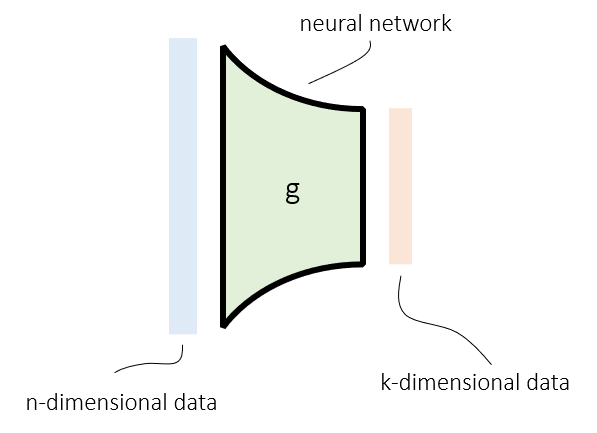

## The auto-encoder

How are these networks trained? The way the **auto-encoder** does so is both simple and brilliant. The first part of the auto-encoder is equivalent to what is drawn above (that is $g$). As second step, it appends the encoding part with a *decoding part* that decodes the lower-dimensional data back to its original size ($\in \mathbb{X}^n$). The outcome ($y =: \hat{x}$) is compared to the the input so it learns both how to encode the input signals and decode it back. 

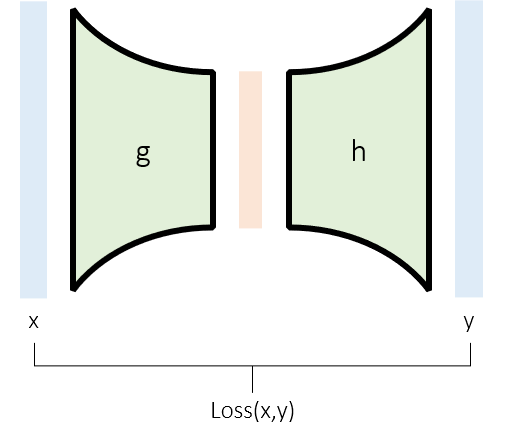

The auto-encoder is the concatanation of encoder and decoder: 

$$
y = g(h(x)).
$$

And the loss is simply given as

$$
f_L = L \left( x, y \right) = L \left( x, g(h(x)) \right).
$$

in which $L$ is mostly chosen to be the MSE-loss. 

****
**What is the crucial underlying assumption auto-encoders (need) to make on the data in order to be efficiently utilized? (hint: on what assumption relies dimension reduction?) And can you justify this assumption?** 
****



## Generating new data!

The encoded signal (indicated with in transparant red above) lives in a low-dimensional space. This space is often referred to as the **latent space** and denoted by $\mathbb{Z}$ ($=\mathbb{R}^k$). An interesting and widely adopted feature of auto-encoders is that is has to potential of *generating new data samples*. Generating new data merely uses the learned decoder part and feedforwards "unseen" **latent vectors** $z_{sample}$ ($ \in \mathbb{Z}$), thereby reproducing output signals that are potentially new: 

$$
x_{new} = h \left( z_{sample} \right)
$$

In the following you will play around with the 2D handwritten dataset and design and implement your own auto-encoder.

****
**Why is generating new data useful? Can you come up with any out-of-the-box examples deploying this technique?**
****

## The 2D-MNIST data set

First, we load the dataset and plot some of its samples.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


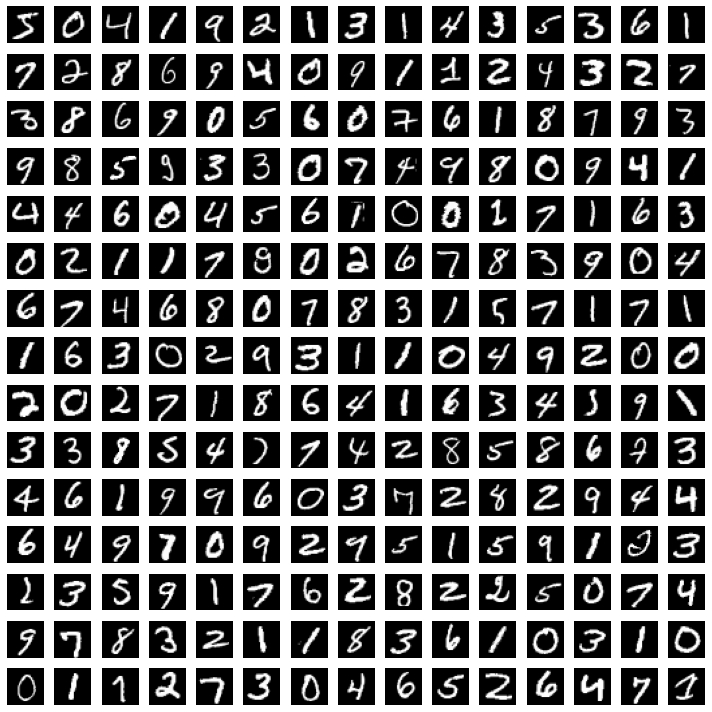

In [ ]:
#Download the MNIST dataset
mnist_data = datasets.MNIST('./data',
               transform=transforms.ToTensor(),
               download=True)

#Put it into a dataloader for easier handling in pytorch
mnist_loader = torch.utils.data.DataLoader(mnist_data,batch_size=128,shuffle=False)

# Show some example images
nr_dig = 15
fig, axs = plt.subplots(nr_dig, nr_dig, figsize=(10, 10))
for i in range(int(nr_dig*nr_dig)):
    x, _ = mnist_data[i]
    ax = axs[i // nr_dig][i % nr_dig]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Implementing the auto-encoder

The whole auto-encoder is implemented in the code block below which consists of the 3 classes: `Encoder`, `Decoder` and `Autoencoder`. We would like you to implement the following specific architecture:

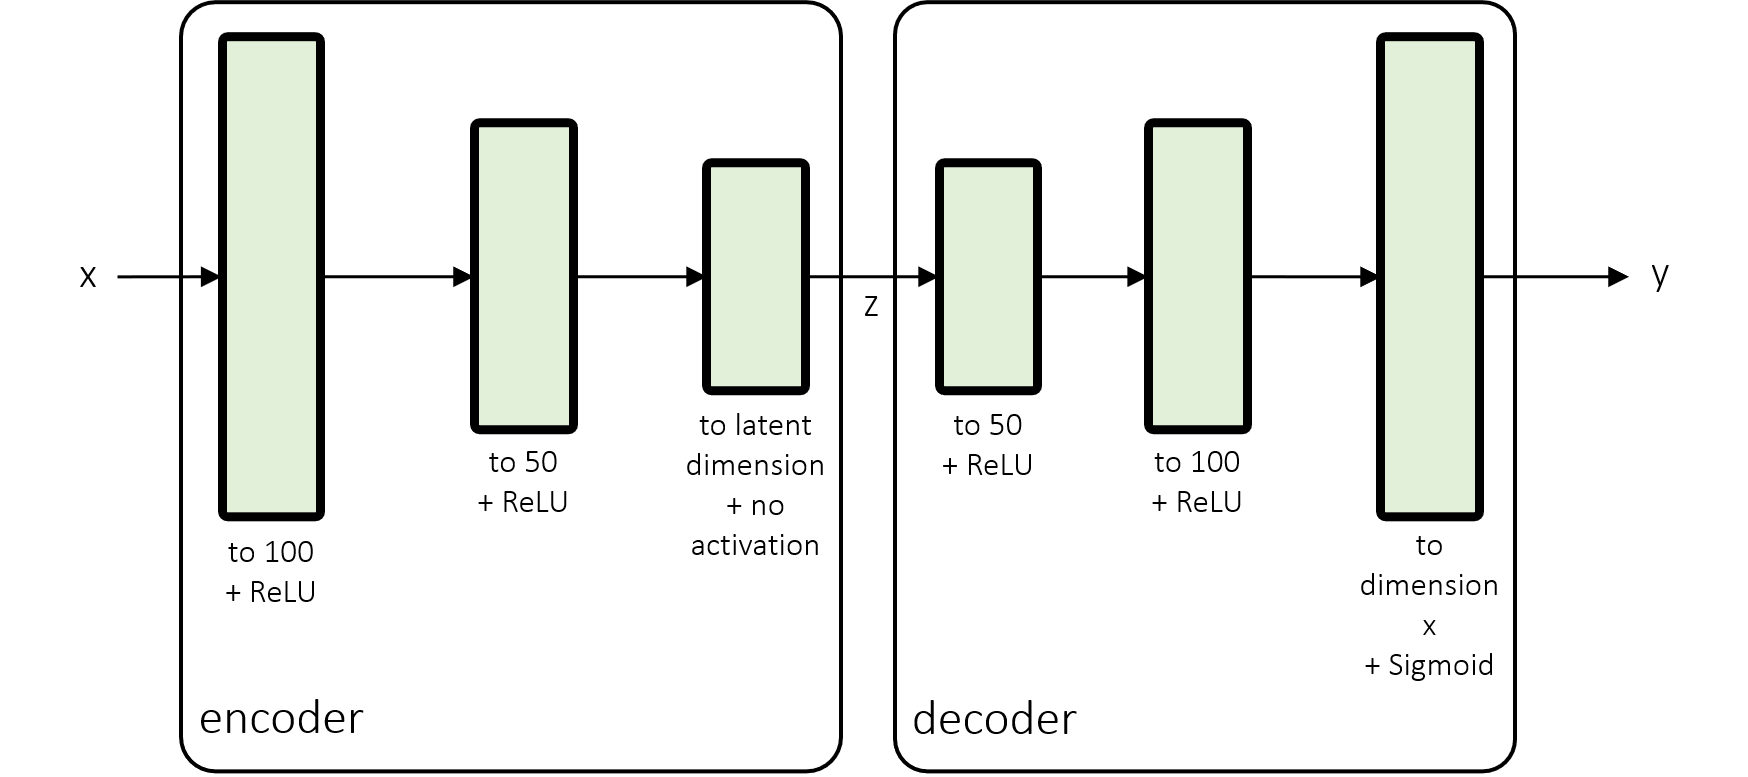

****
**What do the transparant green blocks represent exactly? What does the "to [nr]" means? And what about the "+ ReLU/Sigmoid"?** 
****

In [ ]:
#encoder
class Encoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(Encoder, self).__init__()

        ########################################################################
        #    TODO: Create the necessary layers                                 #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        

    def forward(self, x):

        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        ########################################################################
        #    TODO: Apply final layer of the enconder                           #
        #    NOTE: must you apply an activation, as before?                    #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return x

#decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(Decoder, self).__init__()

        self.linear1 = nn.Linear(latent_dims, hdim[1])
        self.linear2 = nn.Linear(hdim[1], hdim[0])
        self.linear3 = nn.Linear(hdim[0], s_img*s_img)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        
        ########################################################################
        #    TODO: Apply full forward function                                 #
        #    NOTE: Please have a close look at the forward function of the     #
        #    encoder                                                           #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return z

#autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim = [100, 50]):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(latent_dims, s_img, hdim)
        self.decoder = Decoder(latent_dims, s_img, hdim)

    def forward(self, x):

        ########################################################################
        #    TODO: concatanate encoder and decoder                             #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

We will test the auto-encoder on a dummy tensor and summarize the network using the `summary` function. 

In [ ]:
#test auo-encoder
n_samples, in_channels, s_img, latent_dims = 3, 1, 28, 2
hdim = [100, 50] #choose hidden dimension

#generate random sample
x = torch.randn((n_samples, in_channels, s_img, s_img))
print(x.shape)

#initialize model
model = Autoencoder(latent_dims, s_img, hdim = hdim)
x_hat = model(x)

#compare input and output shape
print('Output check:', x_hat.shape == x.shape)
print('')

#summary of auto-encoder
summary(model, (in_channels, s_img, s_img), device='cpu') # (in_channels, height, width)

torch.Size([3, 1, 28, 28])
Output check: True

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 50]           5,050
              ReLU-4                   [-1, 50]               0
            Linear-5                    [-1, 2]             102
           Encoder-6                    [-1, 2]               0
            Linear-7                   [-1, 50]             150
              ReLU-8                   [-1, 50]               0
            Linear-9                  [-1, 100]           5,100
             ReLU-10                  [-1, 100]               0
           Linear-11                  [-1, 784]          79,184
          Sigmoid-12                  [-1, 784]               0
          Decoder-13            [-1, 1, 28, 28]         

****
**Is the architecture in agreement with what it should be?**
****

We copy-pasted the `train` function of previous assignment:


In [ ]:
def train(train_loader, net, optimizer, criterion, device = 'cpu'):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        device: whether the network runs on cpu or gpu
    """
  
    avg_loss = 0    

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # convert the inputs to run on GPU if set
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss

    return avg_loss/len(train_loader)

def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device              

Please train both an auto-encoder with 2 (AE2) and 3 (AE3) latent dimensions seperately. 

****
**Why would you choose the MSE-loss? Why not Cross-Entropy?**
****

In [ ]:
#Set the number of dimensions of the latent space
latent_dims = [2,3]
s_img = np.size(mnist_data[1][0], axis = 2) #get image size (height = width) from a data sample
hdim = [100, 50]

# Create a writer to write to Tensorboard
writer = SummaryWriter()

#Create instance of Autoencoder
device = try_gpu()

AE2 = Autoencoder(latent_dims[0], s_img, hdim = hdim).to(device) #2-dimensional latent space
AE3 = Autoencoder(latent_dims[1], s_img, hdim = hdim).to(device) #3-dimensional latent space

# Create loss function and optimizer
criterion = F.mse_loss

optimizer = optim.Adam(AE2.parameters(), lr=5e-4)

# Set the number of epochs to for training
epochs = 20

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(mnist_loader, AE2, optimizer, criterion, device)    

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss}, epoch)      

optimizer = optim.Adam(AE3.parameters(), lr=5e-4)

# Set the number of epochs to for training
epochs = 20

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(mnist_loader, AE3, optimizer, criterion, device)    

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss}, epoch) 

  5%|▌         | 1/20 [00:08<02:50,  8.98s/it]

Evaluation can be done using TensorBoard:

In [ ]:
# Open Tensorboard
%tensorboard --logdir runs/

# For local users only: uncomment the last line, run this cell once and wait for
# it to time out, run this cell a second time and you should see the board.
# %tensorboard --logdir runs/ --host localhost

In [ ]:
# To completely clean your tensorboard uncomment and run the following command.
# !rm -r runs

We would like to evaluate the latent space and how input samples are, if encoded, distributed across it. `plot_latent` is a function that does exactly this for a given data set, `data_loader` and amount of batches, `num_batches`. 

****
**Why did we chose to only train auto-encoders that have very small latent spaces?**
****

In [ ]:
#plot latent space

def plot_latent(model, data_loader, num_batches=100, device = try_gpu()):

    '''
    Plots position of data in latent space (which is either 2D or 3D)

    Args:
      autoencoder: pytorch network that contains an encoder subnetwork
      data_loader: the data we want to plot in latent space
      num_batches: number of batches to use in for the plot

    '''
    # Iterate over all data 
    plt.rcParams['figure.figsize'] = (5,3)
    plt.rcParams['figure.dpi'] = 144

    for idx, data in enumerate(data_loader):

        x, y = data
        z = model.encoder(x.to(device))  #Encode image data
        z = z.to('cpu').detach().numpy() #Get numpy version of data in latent space

        # 2D latent space (single image)
        if np.size(z, axis=1) == 2:
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10') #Add data to plot
        
        #------------------------------------------------------------------------
        # 3D latent space (4 images: 3D image, and 3 x 2D projections onto xy, xz 
        # and yz)
        if np.size(z, axis=1) == 3:
            if idx == 0: #initialize at first iteration
                plt.rcParams['figure.figsize'] = (5,5)
                fig1 = plt.figure()
                plt.rcParams['figure.figsize'] = (15,5)
                fig2 = plt.figure()
                ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
                ax2 = fig2.add_subplot(1, 3, 1)
                ax3 = fig2.add_subplot(1, 3, 2)
                ax4 = fig2.add_subplot(1, 3, 3)
                ax1.grid(False)
                # Hide axes ticks
                ax1.set_xticks([])
                ax1.set_yticks([])
                ax1.set_zticks([])

                #set labels
                ax1.set_xlabel('dimension 1')
                ax1.set_ylabel('dimension 2')
                ax1.set_zlabel('dimension 3')
                ax2.set_xlabel('dimension 1')
                ax2.set_ylabel('dimension 2')
                ax3.set_xlabel('dimension 1')
                ax3.set_ylabel('dimension 3')
                ax4.set_xlabel('dimension 2')
                ax4.set_ylabel('dimension 3')

            ax1.scatter3D(z[:, 0], z[:, 1], z[:, 2], c=y, cmap='tab10');
            ax2.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10');
            ax3.scatter(z[:, 0], z[:, 2], c=y, cmap='tab10');
            ax4.scatter(z[:, 1], z[:, 2], c=y, cmap='tab10');
            
            if idx > num_batches:
                fig1.tight_layout()
                fig2.tight_layout()

        # Stop if we've reach the maximum number of batches
        if idx > num_batches:
            if np.size(z, axis=1) == 2:
                plt.colorbar()
            break

We will now plot the encodings of the first `num_batches` batches of the dataset.  

In [ ]:
print('Latent space for AE2: 2D')
plot_latent(AE2, mnist_loader, num_batches = 100)

print('Latent space for AE3: 3D and 2D-projections on the main planes')
plot_latent(AE3, mnist_loader, num_batches = 100)

****
**Note how the points in the latent space are quite spread out and have many gaps in between. Can you think of a reason why this happens and more importantly, why this could become an issue?**
****

As next step, we would like to generate "new" data. This is very easy: take random points in the latent space and use the learned decoder part of the network to create its associated reproductions. This is done in `plot_reconstruct` below. Observe that the function does not choses the latent vectors really randomly. Does that matter?

In [ ]:
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):

    '''
    Plots reconstruction from a decoder for variables between r0 bounds and r1 bounds with a stepsize of n

    Args:
      autoencoder: pytorch network that contains a decoder subnetwork with input size of two
      r0: bounds of first latent variable
      r1: bounds of second latent variable
      n: sqrt of amount of numbers to decode

    '''

    w = 28 #side length of MNIST images

    img = np.zeros((n*w, n*w)) #prepare large image to hold all decoded images
    
    #Iterate over bounds with stepsize n
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):

            z = torch.Tensor([[x, y]]).to(device) #Create a tensor from inputs

            x_hat = autoencoder.decoder(z) #Run decoder

            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy() #Reshape to mnist sized image

            # Place decoded image in larger image:
            #
            #  _____________________ 
            # |r00 |r01 | ...  | r0n|
            # |____|____|      |____|    
            # |r10 |                |
            # |____|             :  | 
            # |  :               :  |
            # |  :               :  |
            # |____             ____|
            # |rn0 |    ....   |rnn |
            # |____|___________|____|
            #
            # in which rij is the reconstructed image produced by the decoder 
            # for the latent vector [r0[i], r1[j]]

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

    plt.imshow(img, extent=[*r0, *r1]) #Show complete image

Use the reconstruction function and plot back the the reconstructions of the new samples. 

In [ ]:
plot_reconstructed(AE2)

At some places it clearly generates digit-like objects, but for most of the points in the latent space it certainly does not. This has the direct effect that randomly taking a sample close to the origin of the latent space often results in "meaningless" reproductions. Not surprisingly, this has to do with the way the latent space is organized, or better, how it is non-organized at all! So far, we only penalized the outcomes.

# A8.2 Variational Auto Encoders


## Learning distributions instead of points

Variational auto-encoders (VAE's) have a way of penalizing the structure of the latent space. Instead of generating points, the VAE's encoder part generates a distribution. For the decoder part, *$z$ is chosen randomly from that learned distribution*. This yields a latent space that is **continuous** (two point close in the latent space yield similar reproductions) and **complete** (all points in the latent space, at least close enough to the origin, yield meaningful reproductions). The following scheme gives an overview of the VAE.

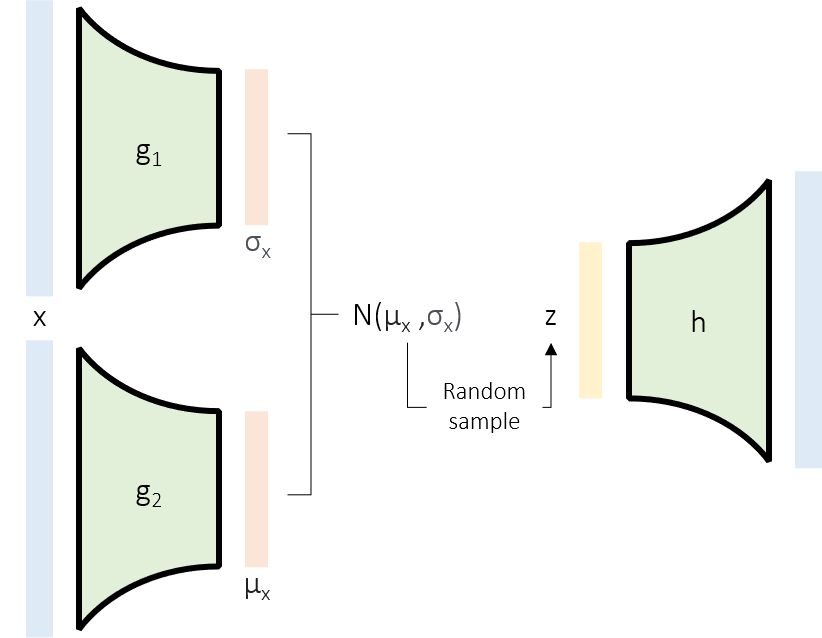


The latent space is regularized if the distribution is penalized. In the loss term an extra term is added that accounts for this penalty:

$$
\begin{aligned}
f_{L} &= \underbrace{L (x, h(z))}_{\text{reproduction term}} + \underbrace{R \left(\mathcal{N} (\mu_x, \sigma_x), \mathcal{N} (0, I) \right)}_{\text{regularization term}} \\
&= L (x, h(z)) + R \left(\mathcal{N} (g_2 (x), g_1(x)), \mathcal{N} (0, I) \right)
\end{aligned}
$$

in which the regularization term tries to make the network learn a normal distribution close to one with 0 mean and a variance of 1 (for all its features). 

****
**For we already take a random sample from the learned distribution as input for the decoder, is it really necessary to penalize the distribution? Why (not)? Furthermore, can you argue why the variational auto-encoder indeed has the two properties (continuity and completeness)?** 
****

## The reparameterization trick

In the above proposed model, backpropagation is not possible. The **reparameterization trick** is used instead to overcome it. Instead of sampling $z$ from the learned distribution, is computes $z$ as 

$$
z = \mu_x +  \sigma_x \zeta= g_1(x) + g_2 (x) \zeta
$$

in which $\zeta$ is randomly sampled from $\mathcal{N} (0, I)$.  Backpropagation is perfectly possible again! 

****
**Wait! Why is that perfectly possible again? How can we backpropagate if there still is a random variable?**
****

Please implement the VAE in the following code block (same amount of neurons in $g_1$ and $g_2$ as in $g$ previously). You can use the same decoder as before. 

In [ ]:
#encoder
class VarEncoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(VarEncoder, self).__init__()
        
        #layers for g1
        self.linear1_1 = nn.Linear(s_img*s_img, hdim[0])
        self.linear2_1 = nn.Linear(hdim[0], hdim[1])
        self.linear3_1 = nn.Linear(hdim[1], latent_dims)

        #layers for g2
        self.linear1_2 = nn.Linear(s_img*s_img, hdim[0])
        self.linear2_2 = nn.Linear(hdim[0], hdim[1])
        self.linear3_2 = nn.Linear(hdim[1], latent_dims)

        self.relu    = nn.ReLU()

        #distribution setup
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(try_gpu()) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(try_gpu())
        self.kl = 0

    ########################################################################
    #    TODO: Define functions for:                                       # 
    #    1. the Kullback-Leibner loss "kull_leib"                          #
    #    2. the Reparameterization trick                                   #
    ########################################################################

    pass

    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    def forward(self, x):

       
        ########################################################################
        #    TODO: Create mean and variance                                    #
        ########################################################################

        pass

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        #reparameterize to find z
        z = self.reparameterize(mu, sig)

        #loss between N(0,I) and learned distribution
        self.kl = self.kull_leib(mu, sig)

        return z

#decoder: same as before

#autoencoder
class VarAutoencoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim = [100, 50]):
        super(VarAutoencoder, self).__init__()

        self.encoder = VarEncoder(latent_dims, s_img, hdim)
        self.decoder = Decoder(latent_dims, s_img, hdim)

    def forward(self, x):

        z = self.encoder(x)
        y = self.decoder(z)

        return y

Since we now have an extra loss term we need to modify our training loop a bit.

In [ ]:
def train_vae(train_loader, net, optimizer, device = try_gpu()):
    """
    Trains variational autoencoder network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).        
        device: whether the network runs on cpu or gpu                
    """
  
    avg_loss = 0    

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # convert the inputs to run on GPU if set
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = ((inputs - outputs)**2).sum() + net.encoder.kl

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss

    return avg_loss/len(train_loader)

And train! (again train for networks with latent spaces 2D and 3D seperately) 

In [ ]:
#Set the number of dimensions of the latent space
latent_dims = [2,3]
s_img = np.size(mnist_data[1][0], axis = 2)

# Create a writer to write to Tensorboard
writer = SummaryWriter()

#Create instance of Autoencoder
device = try_gpu()

VAE2 = VarAutoencoder(latent_dims[0], s_img).to(device)
VAE3 = VarAutoencoder(latent_dims[1], s_img).to(device)

# Create loss function and optimizer
criterion = F.mse_loss

optimizer = optim.Adam(VAE2.parameters(), lr=5e-4)

# Set the number of epochs to for training
epochs = 10

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train_vae(mnist_loader, VAE2, optimizer, device)    

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss}, epoch)      

optimizer = optim.Adam(VAE3.parameters(), lr=5e-4)

# Set the number of epochs to for training
epochs = 10

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train_vae(mnist_loader, VAE3, optimizer, device)    

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss}, epoch) 

100%|██████████| 10/10 [00:59<00:00,  5.91s/it]


Again, we plot some data points across the learned latent space. 

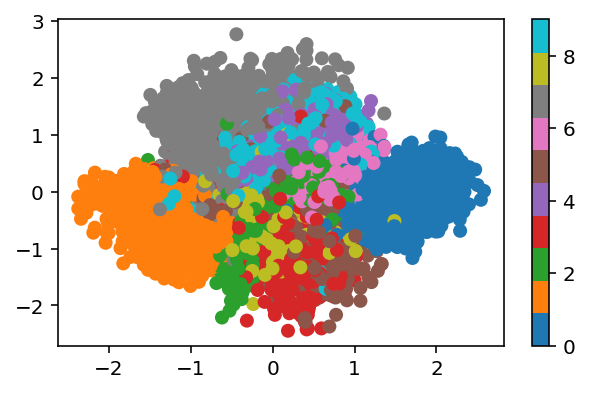

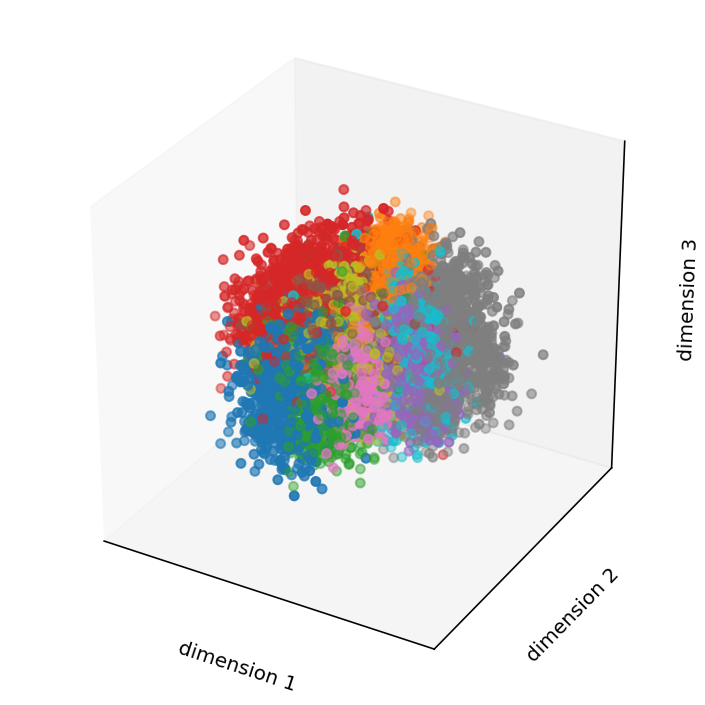

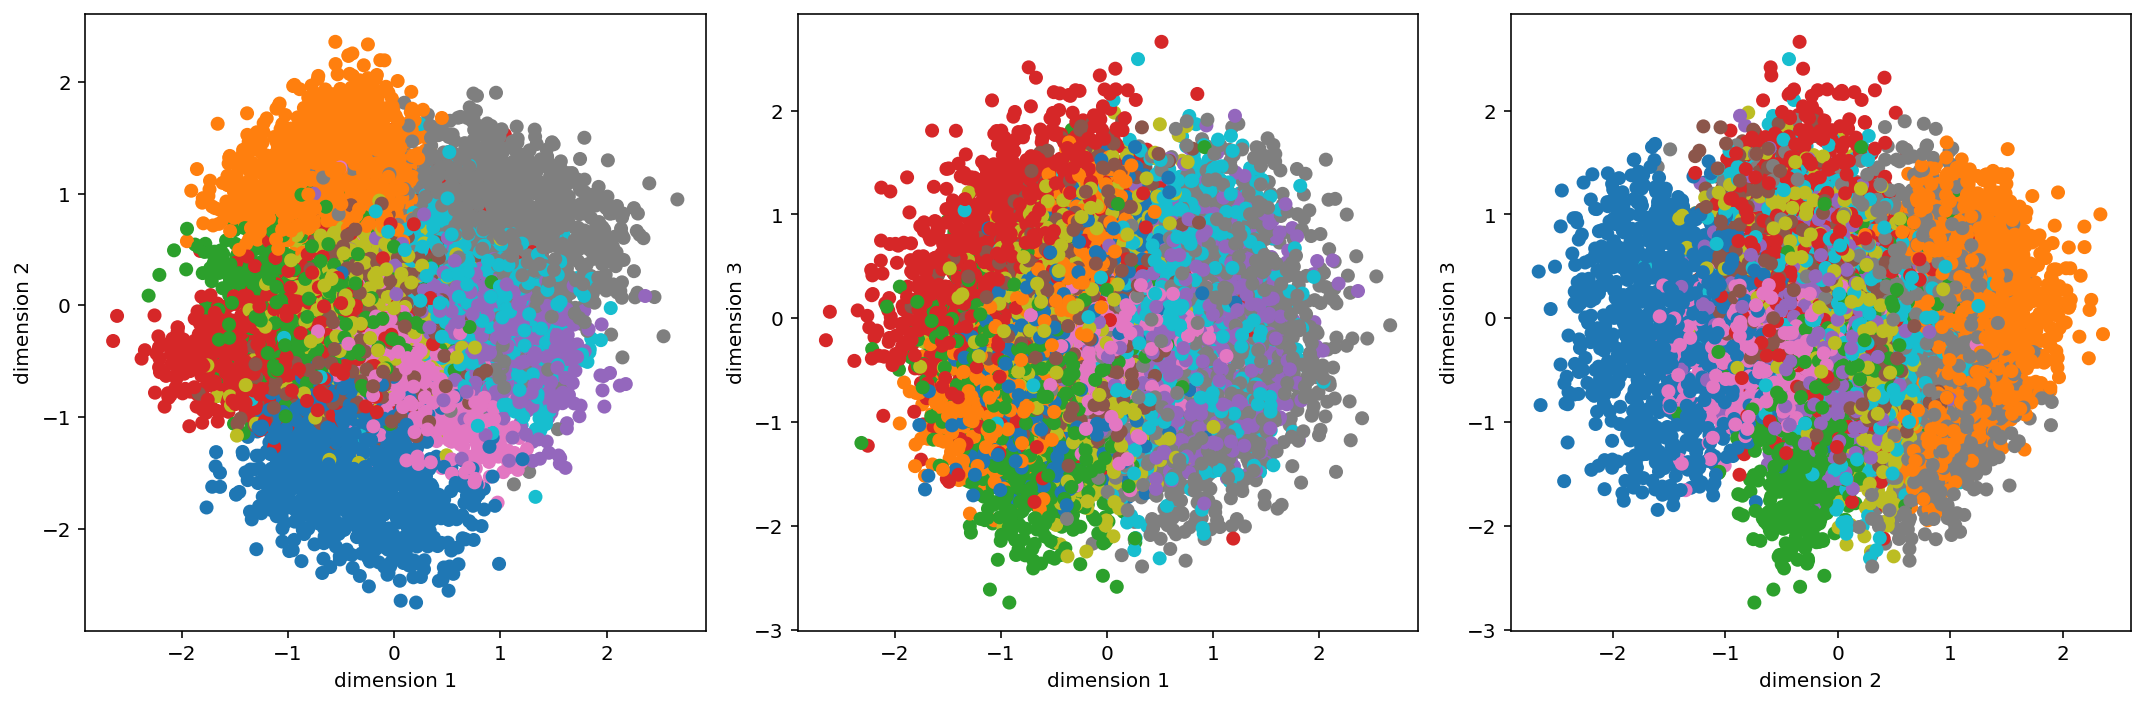

In [ ]:
plot_latent(VAE2, mnist_loader, num_batches = 100)
plot_latent(VAE3, mnist_loader, num_batches = 100)

****
**What is different? Is it better?**
****

Now decode some grid sampled latent vectors back for the 2-dimensional latent space auto-encoder.

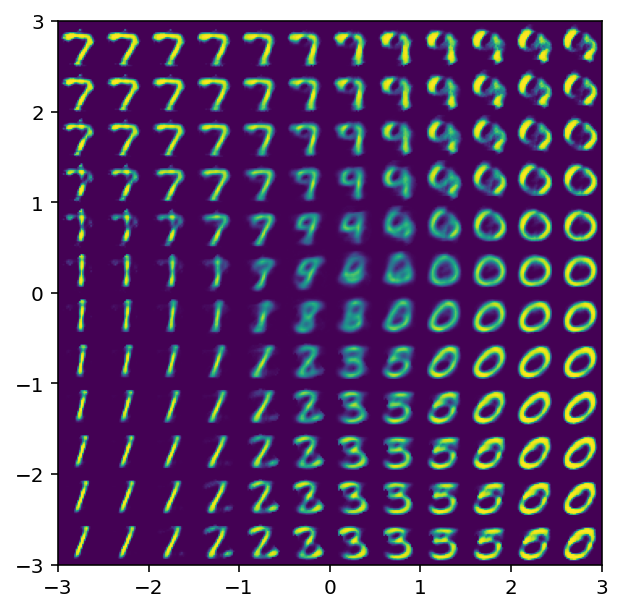

In [ ]:
plot_reconstructed(VAE2)

Observe that there is much less gibberish across the whole grid! 

That is it! You are done with all assignments. Well done! We hope you liked it, and if you have any feedback on the assignments in general, feel free to contact us. 

Good luck with the reproduction project, the seminars, the exam and the many more DL projects to come!! :)